# INFO 3402 – Class 37: Analyzing and modelling autoregression

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

First things first, we need to install a new library: "fbprophet" to do some of the time series modeling later in the notebook. This takes a few minutes to install.

**AT THE TERMINAL WINDOW**, run these two commands and agree to update when it requests:

`conda update --all`  
`conda install -c conda-forge fbprophet`

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm

from fbprophet import Prophet

We will return to the DIA passenger activity data we first explored back in Class 13 with data cleaning.

In [2]:
dia_passengers = pd.read_csv('dia_passengers.csv',parse_dates=['date'])

dia_passengers.head()

,date,passengers
0,1995-02-01,70562.0
1,1995-03-01,2842669.0
2,1995-04-01,2422712.0
3,1995-05-01,2532545.0
4,1995-06-01,2803418.0


Visualize the data.

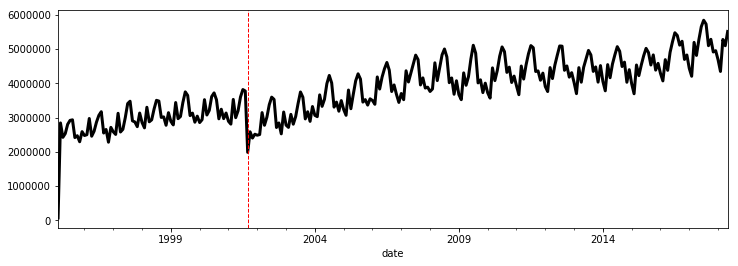

In [3]:
# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(12,4))

# Put the "date" column as an index, access the remaining "passengers" column, and plot on the ax defined above
dia_passengers.set_index('date')['passengers'].plot(c='k',lw=3,ax=ax)

# Make a vertical red line on September 11, 2001
ax.axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

Recall that statsmodels provides a variety of tools for "decomposing" a time-series into its seasonal, trend, and residual components.

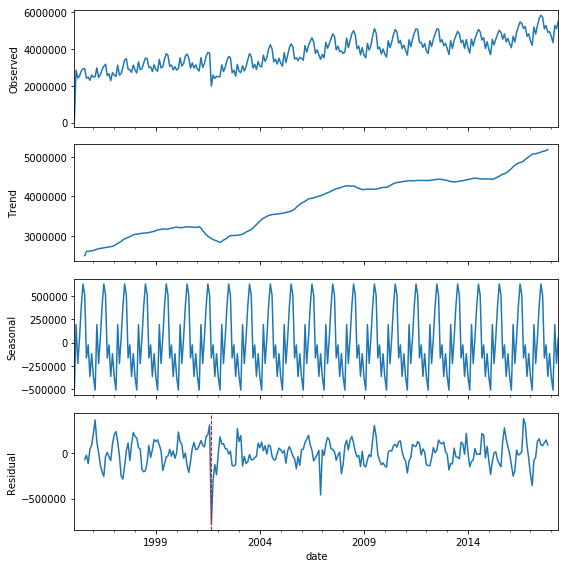

In [4]:
# This works best with a series having Timestamp/datetime objects as index
# So set the index to date and retrieve appropriate column to make a Series
decomposition = sm.tsa.seasonal_decompose(dia_passengers.set_index('date')['passengers'],model='additive')

plt.rcParams["figure.figsize"] = (8,8)
f = decomposition.plot()

f.axes[-1].axvline(pd.Timestamp('2001-09-11'),color='r',ls='--',lw=1)

Do the same feature engineering we did in Class 36.

In [5]:
# Convert datetime/Timestamp objects into simpler floats
dia_passengers['months_since_opening'] = (dia_passengers['date'] - pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')

# Get the rolling mean for trend modelling
dia_passengers['rolling_mean_passengers'] = dia_passengers['passengers'].rolling(12).mean()

# Extract month for fixed effects modelling
dia_passengers['month'] = dia_passengers['date'].apply(lambda x:x.month)

# Inspect
dia_passengers.tail()

,date,passengers,months_since_opening,rolling_mean_passengers,month
275,2018-01-01,4685586.0,276.013881,5.135843e+06,1
276,2018-02-01,4345062.0,277.032383,5.147536e+06,2
277,2018-03-01,5278712.0,277.952319,5.154608e+06,3
278,2018-04-01,5096401.0,278.970821,5.178232e+06,4
279,2018-05-01,5511995.0,279.956467,5.198296e+06,5


Train the same linear regression models we used in Class 36.

In [6]:
m0 = smf.ols('passengers ~ months_since_opening',data=dia_passengers).fit()

m1 = smf.ols('rolling_mean_passengers ~ months_since_opening',data=dia_passengers).fit()

m2 = smf.ols('passengers ~ months_since_opening + C(month)',data=dia_passengers).fit()


Create the DataFrame for predictions going forward in time.

In [7]:
predict_passengers = pd.DataFrame({'date':pd.date_range('2017-01-01','2025-01-01',freq='M')},
                                  index=range(263,263+96))

predict_passengers['months_since_opening'] = (predict_passengers['date'] - pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
predict_passengers['month'] = predict_passengers['date'].apply(lambda x:x.month)

Make the predictions.

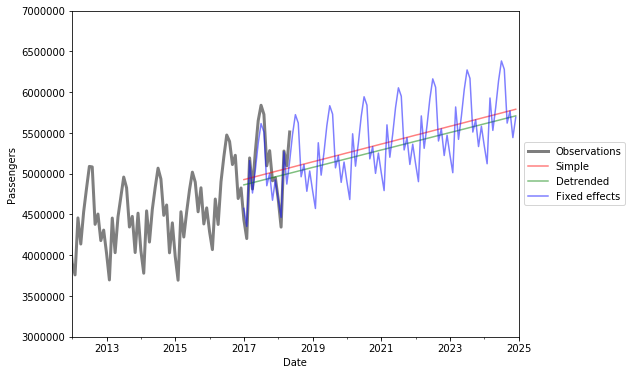

In [8]:
predict_passengers['m0'] = m0.predict({'months_since_opening':predict_passengers['months_since_opening']})
predict_passengers['m1'] = m1.predict({'months_since_opening':predict_passengers['months_since_opening']})
predict_passengers['m2'] = m2.predict({'months_since_opening':predict_passengers['months_since_opening'],
                                       'month':predict_passengers['month']})

f,ax = plt.subplots(1,1,figsize=(8,6))

dia_passengers.plot(x='date',y='passengers',ax=ax,c='k',label='Observations',lw=3,alpha=.5)
predict_passengers.plot(x='date',y='m0',ax=ax,c='r',label='Simple',alpha=.5)
predict_passengers.plot(x='date',y='m1',ax=ax,c='g',label='Detrended',alpha=.5)
predict_passengers.plot(x='date',y='m2',ax=ax,c='b',label='Fixed effects',alpha=.5)
ax.set_xlim((pd.Timestamp('2012-01-01'),pd.Timestamp('2025-01-01')))
ax.set_ylim(3e6,7e6)
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_xlabel('Date')
ax.set_ylabel('Passengers');

## Auto-correlation

One of the key assumptions about regression we discussed in Classes 33 and 34 was the independence of observations. In many forms of data, this is a reasonable assumption: countries' behavior is independent from other countries, people's survey responses are independent from other people's, *etc*.

This assumption breaks down with time series data where observations one day tend to be *strongly* correlated with observations for preceding and subsequent days: the weather yesterday is like the weather today, the price of a stock yesterday is like the price of a stock today, *etc*.

Use pandas's `.shift()` method to create new columns that are shifted by a single or multiple rows so we can correlate passengers in one month with passenger values in adjacent months.

In [9]:
dia_passengers['passengers_shift_1'] = dia_passengers['passengers'].shift(1)
dia_passengers['passengers_shift_2'] = dia_passengers['passengers'].shift(2)
dia_passengers['passengers_shift_3'] = dia_passengers['passengers'].shift(3)
dia_passengers['passengers_shift_4'] = dia_passengers['passengers'].shift(4)
dia_passengers.head()

,date,passengers,months_since_opening,rolling_mean_passengers,month,passengers_shift_1,passengers_shift_2,passengers_shift_3,passengers_shift_4
0,1995-02-01,70562.0,1.018501,NaN,2,NaN,NaN,NaN,NaN
1,1995-03-01,2842669.0,1.938438,NaN,3,70562.0,NaN,NaN,NaN
2,1995-04-01,2422712.0,2.956940,NaN,4,2842669.0,70562.0,NaN,NaN
3,1995-05-01,2532545.0,3.942586,NaN,5,2422712.0,2842669.0,70562.0,NaN
4,1995-06-01,2803418.0,4.961087,NaN,6,2532545.0,2422712.0,2842669.0,70562.0


Now correlate "passengers", "passengers_shift_1", "passengers_shift_2", *etc*. The correlations for "passengers" (first columns) at adjacent points in time is *extremely* strong: this is clearly a violation of the independence assumption because the values at different points in time are not independent but strongly correlated with the preceding and succeeding values.

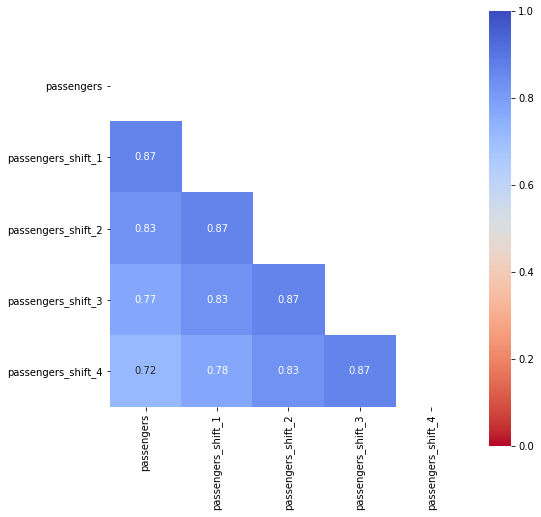

In [10]:
dia_passengers_corr = dia_passengers[['passengers','passengers_shift_1','passengers_shift_2','passengers_shift_3','passengers_shift_4']].corr()

# Using masking code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
dia_passengers_mask = np.zeros_like(dia_passengers_corr)
dia_passengers_mask[np.triu_indices_from(dia_passengers_mask)] = True

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(8,8))

# Make a heatmap
sb.heatmap(dia_passengers_corr,vmin=0,vmax=1,mask=dia_passengers_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')


This correlation in adjacent time points' values is called **[autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)**. Also note how even the shifted variables are also correlated with each other, we would need to control for the correlations in these other shifts/lags to recover the "true" correlation in the adjacent time series. **[partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)** does exactly this.

statsmodels has two functions in its `tsa` (time series analysis) class to plot out both the autocorrelation and partial autocorrelation in a time series. The x-axis is different lags (the shifting of different amounts we did above). The y-axis is the correlation values, identical to the "passengers" column in the heatmap above. These plots are called [correlograms](https://en.wikipedia.org/wiki/Correlogram).

Passenger values are correlated at 0.87 at lag-1, 0.83 at lag-2, 0.77 as lag-3, and 0.72 at lag-4. In this case, we plotted out the correlations all the way to 50 lags with `plot_acf`. The blue curves are 95% confidence intervals, values *outside* this range are likely to be statistically significant correlations while values *within* this range cannot be distinguished from random noise.

The *autocorrelation* is the simple correlation between values at different lags, but does not control for the fact that these correlations are correlated with other time lags: lag-1's correlation with lag-2 influences lag-1's correlation with lag-0, *etc*. The *partial autocorrelation* controls for these lagged values and recovers a more independent correlation value.

The partial autocorrelations still show strong signals at 12 months, 24 months, *etc*. This captures the fact that monthly DIA activity in January one year is similar to January in the next year. In the figures below, I've marked lag-12, lag-24, *etc*. with dashed red lines.

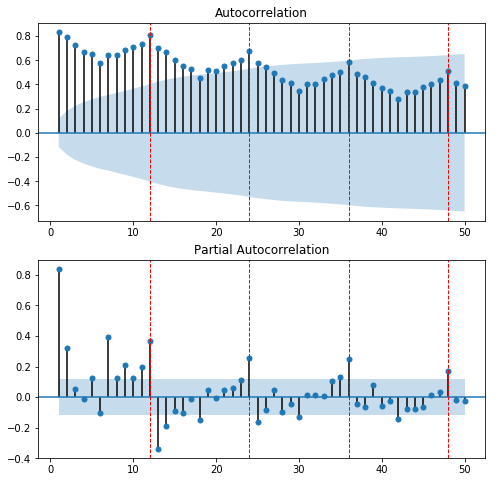

In [11]:
f,axs = plt.subplots(2,1,figsize=(8,8))

fig1 = sm.graphics.tsa.plot_acf(dia_passengers['passengers'],zero=False,lags=50,ax=axs[0],alpha=.05)
fig2 = sm.graphics.tsa.plot_pacf(dia_passengers['passengers'],zero=False,lags=50,ax=axs[1],alpha=.05)

for ax in axs:
    ax.axvline(12,c='r',ls='--',lw=1)
    ax.axvline(24,c='r',ls='--',lw=1)
    ax.axvline(36,c='r',ls='--',lw=1)
    ax.axvline(48,c='r',ls='--',lw=1)

pandas can also make an autocorrelation correlograms with `.plotting.autocorrelation_plot`. The dashed lines are the confidence interval where values above this are statistically significant correlation and unlikely to be noise (as above).

(1, 50)

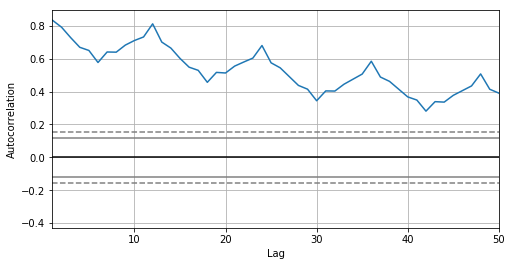

In [12]:
f,ax = plt.subplots(1,1,figsize=(8,4))

ax = pd.plotting.autocorrelation_plot(dia_passengers['passengers'],ax=ax)
ax.set_xlim((1,50))

## Prophet

[Prophet](https://facebook.github.io/prophet/) is a time series forecasting tool developed (and obviously used by) data scientists at Facebook. There are a variety of more advanced statistical methods for modelling time series ([ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model), [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), SARIMA, *etc*.) but these often involve doing data-drive grid search to find appropriate parameters or having deep understanding of the data or a theory to translate into parameters. Needless to say, these forecasting methods are outside the scope of the class.

The reason we're looking at Prophet is because it does all of these (and more!), *mostly* automatically. Definitely check out the [documentation](https://facebook.github.io/prophet/) and examples in both R and Python.

I've adapted the [Getting Started](https://facebook.github.io/prophet/docs/quick_start.html#python-api) documentation for our purposes here. Prophet wants a simple DataFrame containing only a column "ds" with timestamps and a column "y" with values for that date.

In [26]:
# Copy the relevant columns to a new DataFrame
prophet_dia_passengers = dia_passengers[['date','passengers']].copy()

# Rename the columns how Prophet wants
prophet_dia_passengers.rename(columns={'date':'ds','passengers':'y'},inplace=True)

# Inspect
prophet_dia_passengers.head()

,ds,y
0,1995-02-01,70562.0
1,1995-03-01,2842669.0
2,1995-04-01,2422712.0
3,1995-05-01,2532545.0
4,1995-06-01,2803418.0


Fit the model. Since this data is at the monthly level, we do not need Prophet to estimate weekly or daily seasonality patterns. If you had data at the weekly or daily level, you probably would want it to estimate those. A few errors in red may be thrown and it should take a couple seconds for the estimation to finish.

In [56]:
m3 = Prophet(weekly_seasonality=False,daily_seasonality=False).fit(prophet_dia_passengers)

/Users/briankeegan/anaconda/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/Users/briankeegan/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We can use the `make_future_dataframe` method attached to the `m5` model we just estimated to make predictions into the future. Let's estimate a decade into the future, or 10 years \* 12 months/year = 120 months. Make sure to specify the "freq='M'" option, or it will default to daily estimates which doesn't make much sense for our monthly data.

In [57]:
m3_future = m3.make_future_dataframe(periods=120,freq='M')

# Inspect the tail to make sure it's monthly
m3_future.tail()

,ds
395,2027-12-31
396,2028-01-31
397,2028-02-29
398,2028-03-31
399,2028-04-30


In [58]:
m3_forecast = m5.predict(m3_future)

# Lots of columns returned, just look at the choice ones
m3_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
395,2027-12-31,6.107267e+06,5.443866e+06,6.810075e+06
396,2028-01-31,5.953094e+06,5.264033e+06,6.695520e+06
397,2028-02-29,6.636184e+06,5.949019e+06,7.362393e+06
398,2028-03-31,6.332202e+06,5.663873e+06,7.095407e+06
399,2028-04-30,6.585585e+06,5.900625e+06,7.335571e+06


Inspect the predictions made by Prophet. This will include the historical data (black points), the line connecting these points, and the forecast into the future with errors.

Text(0.5, 1.0, 'Observation and Forecast of DIA passengers')

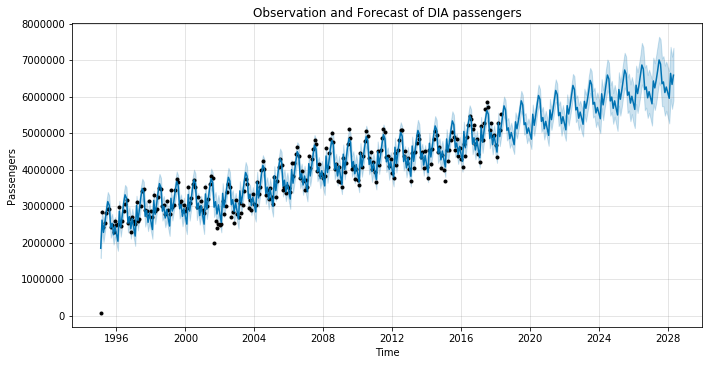

In [122]:
f,ax = plt.subplots(1,1,figsize=(10,5))
_ = m3.plot(m3_forecast,ax=ax)

# Always label your axes
ax.set_xlabel('Time')
ax.set_ylabel('Passengers')
ax.set_title('Observation and Forecast of DIA passengers')

You can also inspect the components of the Prophet model. It just estimates a trend and an annualy cyclical pattern.

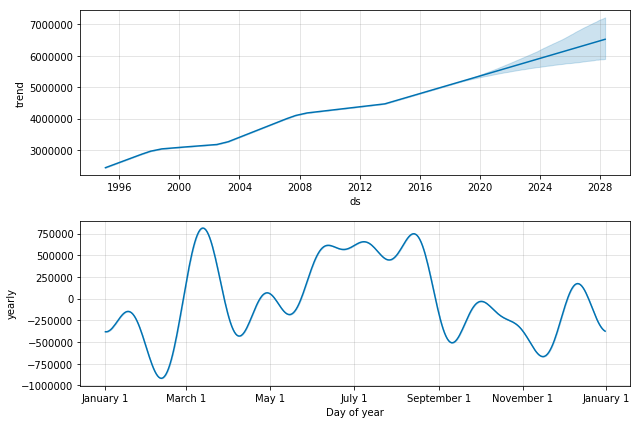

In [60]:
f = m3.plot_components(m3_forecast)

This annual cyclical variation should look similar to the pointplot we made in Class 34 for exploring the month-to-month differences that motivated our fixed effects model (`m2`).

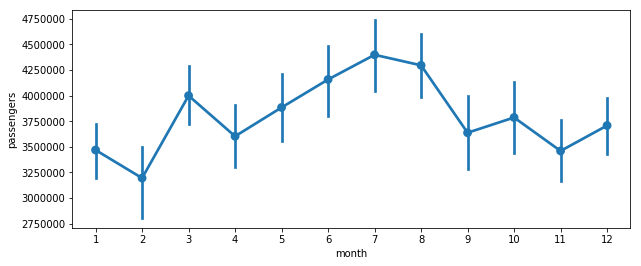

In [47]:
f,ax = plt.subplots(1,1,figsize=(10,4))
sb.pointplot(x='month',y='passengers',data=dia_passengers,ax=ax)

## Make predictions

In [90]:
# Make a range of dates, each month, going to June 1, 2028
future_date_range = pd.date_range('2017-01-01','2028-06-01',freq='M')

# Create an empty DataFrame for these dates, indexed from 263 going forward
predict_passengers = pd.DataFrame({'date':future_date_range},
                                  index=range(263,263+len(future_date_range)))

# Feature engineer out the months since opening and month, like we did above
predict_passengers['months_since_opening'] = (predict_passengers['date'] - pd.Timestamp('1995-01-01'))/pd.Timedelta(1,'M')
predict_passengers['month'] = predict_passengers['date'].apply(lambda x:x.month)

predict_passengers.tail()

,date,months_since_opening,month
395,2028-01-31,396.985564,1
396,2028-02-29,397.938356,2
397,2028-03-31,398.956857,3
398,2028-04-30,399.942504,4
399,2028-05-31,400.961005,5


Use the `.predict` method on each of the statsmodels models and extract the "yhat" estimates from the Prophet model.

In [117]:
# Store all the predictions in a dictionary, to be turned into a DataFrame shortly
predictions_d = {}
predictions_d['Observed'] = dia_passengers.loc[200:,'passengers']
predictions_d['Model 0'] = m0.predict({'months_since_opening':predict_passengers['months_since_opening']})
predictions_d['Model 1'] = m1.predict({'months_since_opening':predict_passengers['months_since_opening']})
predictions_d['Model 2'] = m2.predict({'months_since_opening':predict_passengers['months_since_opening'],
                             'month':predict_passengers['month']})
predictions_d['Model 3'] = m3_forecast['yhat']

# Turn dictionary into a DataFrame 
predictions_df = pd.DataFrame(predictions_d)
predictions_df.head()

,Observed,Model 0,Model 1,Model 2,Model 3
0,NaN,NaN,NaN,NaN,1.844715e+06
1,NaN,NaN,NaN,NaN,2.615709e+06
2,NaN,NaN,NaN,NaN,2.278261e+06
3,NaN,NaN,NaN,NaN,2.547452e+06
4,NaN,NaN,NaN,NaN,2.863223e+06


Visualize the predictions. Model 2 (fixed effects) and Model 3 (Prophet) look really similar and definitely capture the monthly cyclical pattern better than the simple regression models (Models 0 and 1).

Text(0, 0.5, 'Passengers')

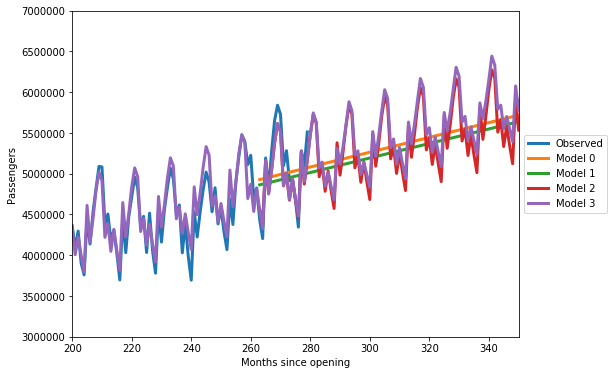

In [100]:
f,ax = plt.subplots(1,1,figsize=(8,6))

predictions_df.plot(lw=3,ax=ax)

ax.set_xlim((200,350))
ax.set_ylim((3e6,7e6))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))

# Always label your axes
ax.set_xlabel('Months since opening')
ax.set_ylabel('Passengers')

Model 3 also made estimates going back in time. We can look at the performance of its predictions compared to the observed data by subtracting one from the other. The performance looks less good now: the Prophet model was off by more than 300,000 passengers (above *and* below) in many months. 

Over the course of a 30-day month, if an average of 10,000 more or fewer passengers were going through than you expected (about 50 planes worth of passengers each day), you might have either very angry passengers waiting in long lines or very angry merchants staffed for empty terminals.

Text(0.5, 1.0, 'Model 3 performance compared to observations')

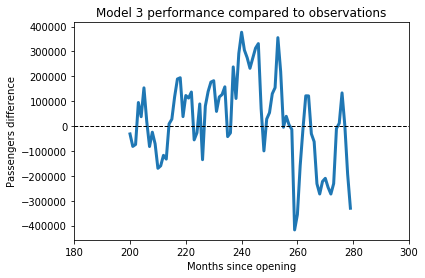

In [115]:
m3_performance = predictions_df['Model 3'] - predictions_df['Observed']

# Zoom in
ax = m3_performance.loc[180:300].plot(lw=3)

# Make a dashed line at 0, which would be perfect performance (no errors in prediction)
ax.axhline(0,c='k',ls='--',lw=1)

# Always label your axes
ax.set_xlabel("Months since opening")
ax.set_ylabel('Passengers difference')
ax.set_title('Model 3 performance compared to observations')

Models 2 and 3 are similar, but not identical. Model 3 has a clear trend of estimating more passengers than Model 2 going into the future. Over a decade, these differences between model predictions compound to a monthly difference of more than 300,000 passengers. 

Your manager or constituents would probably want to know whether they should plan for an extra quarter million passengers each month (or not) in the next decade to make appropriate investments.

Text(0.5, 1.0, 'Difference in predictions, Models 2 and 3')

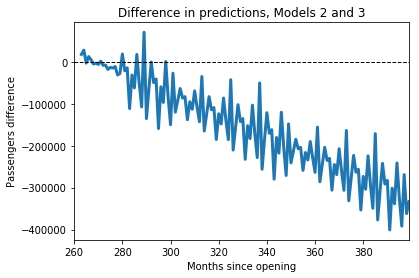

In [114]:
# Subtract Model 3 from Model 2
m2m3_prediction_diff = predictions_df['Model 2'] - predictions_df['Model 3']

# Make the plot, focus on future months by zooming in after 260
ax = m2m3_prediction_diff.loc[260:].plot(lw=3)

# Make a dashed line at 0, which would be perfect agreement between models
ax.axhline(0,c='k',ls='--',lw=1)

# Always label your axes
ax.set_xlabel("Months since opening")
ax.set_ylabel('Passengers difference')
ax.set_title('Difference in predictions, Models 2 and 3')